## PROJET IA / FAKE-NEWS / DEEP-FAKE

## Imports

In [6]:
#pip install keras


In [75]:
import numpy as np
import keras
from keras.models import Sequential
from keras.layers import Activation, Dense, Flatten, Flatten
from keras.optimizers import Adam
from keras.metrics import categorical_crossentropy
from sklearn.metrics import confusion_matrix
import itertools
import os
import cv2
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import torch
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import random
import os
import shutil
import random
from PIL import Image
import matplotlib.pyplot as plt
from torchvision import transforms
from torch.utils.data import DataLoader, random_split
import torch
from torchvision.models import resnet18
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
import os
import shutil
import random
from PIL import Image
import matplotlib.pyplot as plt
from torchvision import transforms, datasets, models
from torch.utils.data import DataLoader, random_split
import torch
import torch.nn as nn
import torch.optim as optim
import torch
import torchvision
import torchvision.transforms as transforms
import os
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

## Path specs

In [17]:


# Define the preprocessing transformations
preprocess = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Function to update paths in text files
def update_paths(file_path, old_path, new_path):
    with open(file_path, 'r') as file:
        lines = file.read().splitlines()
    
    updated_lines = [line.replace(old_path, new_path) for line in lines]
    
    temp_file_path = file_path + "_updated.txt"
    with open(temp_file_path, 'w') as file:
        for line in updated_lines:
            file.write(line + '\n')
    
    return temp_file_path

# Function to copy images to the appropriate directories
def copy_images_to_directory(file_list, target_dir):
    for file_path in file_list:
        if os.path.exists(file_path):
            shutil.copy(file_path, target_dir)
        else:
            print(f"File not found: {file_path}")

# Define the paths to your dataset files
old_base_path = "/kaggle/input/dfdcdfdc/DFDCDFDC/DFDCDFDC/"
new_base_path = "C:/Users/benab/Downloads/DEEP_FAKE_PROJET_IA/kaggle/input/DFDCDFDC/DFDCDFDC/"

client_train_file = "C:/Users/benab/Downloads/DEEP_FAKE_PROJET_IA/kaggle/input/TRAIN_CLIENT.txt"
imposter_train_file = "C:/Users/benab/Downloads/DEEP_FAKE_PROJET_IA/kaggle/input/TRAIN_IMPOSTER.txt"
client_test_file = "C:/Users/benab/Downloads/DEEP_FAKE_PROJET_IA/kaggle/input/TEST_CLIENT.txt"
imposter_test_file = "C:/Users/benab/Downloads/DEEP_FAKE_PROJET_IA/kaggle/input/TEST_IMPOSTER.txt"

# Update paths in the text files
client_train_file_updated = update_paths(client_train_file, old_base_path, new_base_path)
imposter_train_file_updated = update_paths(imposter_train_file, old_base_path, new_base_path)
client_test_file_updated = update_paths(client_test_file, old_base_path, new_base_path)
imposter_test_file_updated = update_paths(imposter_test_file, old_base_path, new_base_path)

# Create directories if they don't exist
train_client_dir = os.path.join("C:/Users/benab/Downloads/DEEP_FAKE_PROJET_IA/kaggle/input/dataset/train/client")
train_imposter_dir = os.path.join("C:/Users/benab/Downloads/DEEP_FAKE_PROJET_IA/kaggle/input/dataset/train/imposter")
val_client_dir = os.path.join("C:/Users/benab/Downloads/DEEP_FAKE_PROJET_IA/kaggle/input/dataset/val/client")
val_imposter_dir = os.path.join("C:/Users/benab/Downloads/DEEP_FAKE_PROJET_IA/kaggle/input/dataset/val/imposter")

os.makedirs(train_client_dir, exist_ok=True)
os.makedirs(train_imposter_dir, exist_ok=True)
os.makedirs(val_client_dir, exist_ok=True)
os.makedirs(val_imposter_dir, exist_ok=True)

# Read the updated file lists
with open(client_train_file_updated, "r") as f:
    client_train_files = f.read().splitlines()
with open(imposter_train_file_updated, "r") as f:
    imposter_train_files = f.read().splitlines()
with open(client_test_file_updated, "r") as f:
    client_test_files = f.read().splitlines()
with open(imposter_test_file_updated, "r") as f:
    imposter_test_files = f.read().splitlines()

# Copy images to the respective directories
copy_images_to_directory(client_train_files, train_client_dir)
copy_images_to_directory(imposter_train_files, train_imposter_dir)
copy_images_to_directory(client_test_files, val_client_dir)
copy_images_to_directory(imposter_test_files, val_imposter_dir)

# Load datasets using ImageFolder
train_dataset = datasets.ImageFolder(root="C:/Users/benab/Downloads/DEEP_FAKE_PROJET_IA/kaggle/input/dataset/train", transform=preprocess)
val_dataset = datasets.ImageFolder(root="C:/Users/benab/Downloads/DEEP_FAKE_PROJET_IA/kaggle/input/dataset/val", transform=preprocess)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False)

# Example of iterating through the data loader
for images, labels in train_loader:
    print(images.shape, labels.shape)
    break  # Just to verify the loader works, remove in actual training


torch.Size([8, 3, 224, 224]) torch.Size([8])


In [18]:
print("The size of train : ",len(train_loader))

10000

In [19]:
print("The size of val : ",len(train_loader))

1244

## Checking the train and val sizes

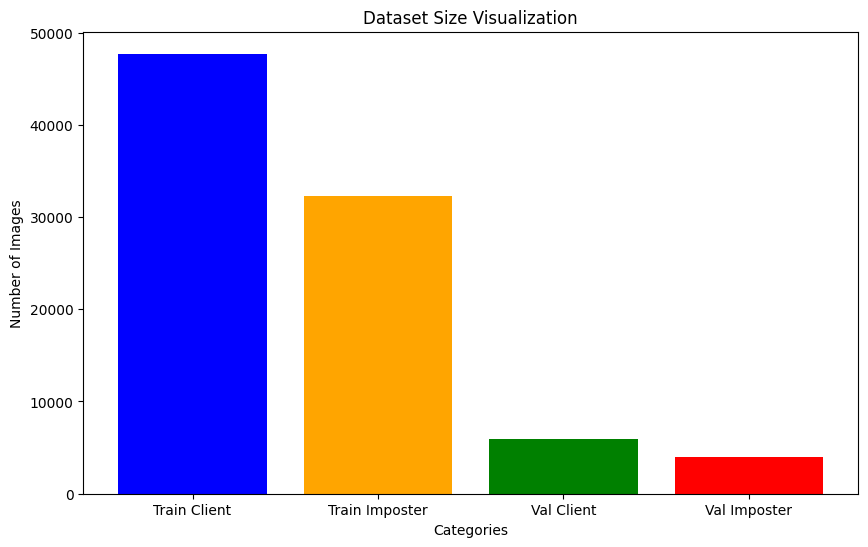

In [21]:
# Define the paths to your dataset directories
train_client_dir = "C:/Users/benab/Downloads/DEEP_FAKE_PROJET_IA/kaggle/input/dataset/train/client"
train_imposter_dir = "C:/Users/benab/Downloads/DEEP_FAKE_PROJET_IA/kaggle/input/dataset/train/imposter"
val_client_dir = "C:/Users/benab/Downloads/DEEP_FAKE_PROJET_IA/kaggle/input/dataset/val/client"
val_imposter_dir = "C:/Users/benab/Downloads/DEEP_FAKE_PROJET_IA/kaggle/input/dataset/val/imposter"

# Function to count the number of images in a directory
def count_images(directory):
    return len([file for file in os.listdir(directory) if file.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.tiff', '.webp'))])

# Count images in each category
train_client_count = count_images(train_client_dir)
train_imposter_count = count_images(train_imposter_dir)
val_client_count = count_images(val_client_dir)
val_imposter_count = count_images(val_imposter_dir)

# Prepare data for visualization
categories = ['Train Client', 'Train Imposter', 'Val Client', 'Val Imposter']
counts = [train_client_count, train_imposter_count, val_client_count, val_imposter_count]

# Create a bar plot
plt.figure(figsize=(10, 6))
plt.bar(categories, counts, color=['blue', 'orange', 'green', 'red'])
plt.xlabel('Categories')
plt.ylabel('Number of Images')
plt.title('Dataset Size Visualization')
plt.show()

## Checking the images of train

Client Images:


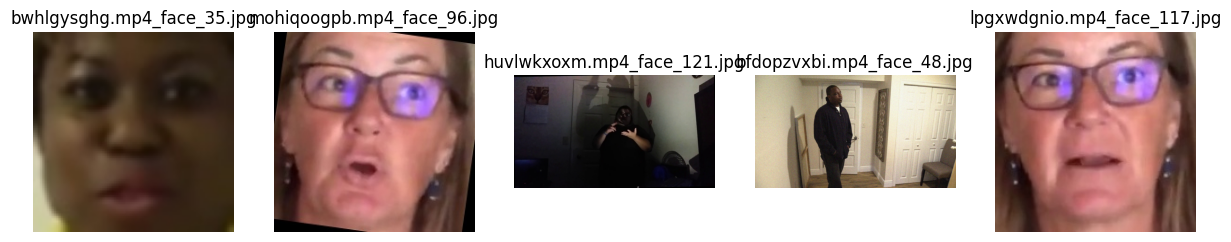

Imposter Images:


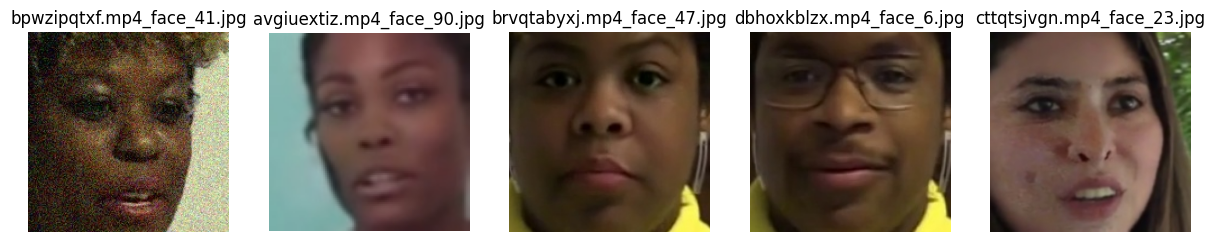

In [30]:

# Function to display random images from a directory
def show_random_images(directory, num_images=5):
    image_files = [os.path.join(directory, file) for file in os.listdir(directory) if file.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.tiff', '.webp'))]
    random_files = random.sample(image_files, num_images)
    
    plt.figure(figsize=(15, 5))
    for i, file in enumerate(random_files):
        img = Image.open(file)
        plt.subplot(1, num_images, i+1)
        plt.imshow(img)
        plt.axis('off')
        plt.title(os.path.basename(file))
    plt.show()

# Show 5 random images of clients
print("Client Images:")
show_random_images(train_client_dir, 5)

# Show 5 random images of imposters
print("Imposter Images:")
show_random_images(train_imposter_dir, 5)


## Balance train client and imposter

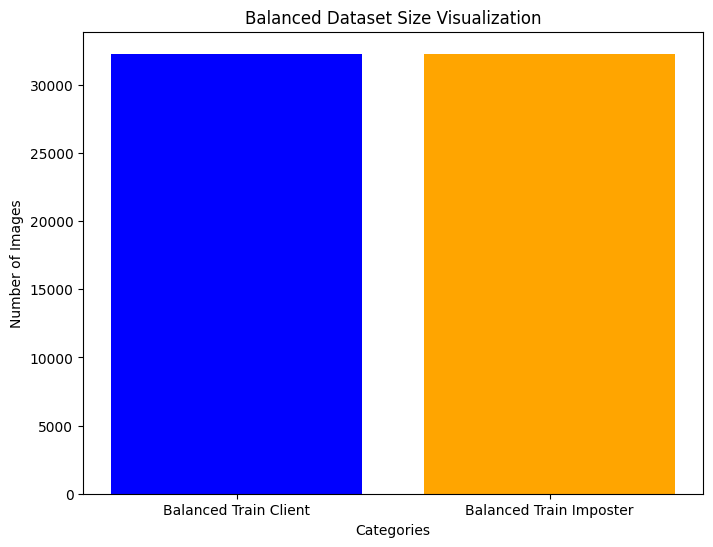

In [36]:
import os
import shutil

# Function to empty a directory
def empty_directory(directory):
    if os.path.exists(directory):
        for file in os.listdir(directory):
            file_path = os.path.join(directory, file)
            try:
                if os.path.isfile(file_path) or os.path.islink(file_path):
                    os.unlink(file_path)
                elif os.path.isdir(file_path):
                    shutil.rmtree(file_path)
            except Exception as e:
                print(f'Failed to delete {file_path}. Reason: {e}')

# Function to copy images to the appropriate directories
def copy_images_to_directory(file_list, target_dir):
    for file_path in file_list:
        if os.path.exists(file_path):
            shutil.copy(file_path, target_dir)
        else:
            print(f"File not found: {file_path}")

# Paths to the dataset directories
train_client_dir = "C:/Users/benab/Downloads/DEEP_FAKE_PROJET_IA/kaggle/input/dataset/train/client"
train_imposter_dir = "C:/Users/benab/Downloads/DEEP_FAKE_PROJET_IA/kaggle/input/dataset/train/imposter"
balanced_train_client_dir = "C:/Users/benab/Downloads/DEEP_FAKE_PROJET_IA/kaggle/input/dataset/balanced_train/client"
balanced_train_imposter_dir = "C:/Users/benab/Downloads/DEEP_FAKE_PROJET_IA/kaggle/input/dataset/balanced_train/imposter"

# Empty the balanced directories if they exist
empty_directory(balanced_train_client_dir)
empty_directory(balanced_train_imposter_dir)

# Create balanced directories
os.makedirs(balanced_train_client_dir, exist_ok=True)
os.makedirs(balanced_train_imposter_dir, exist_ok=True)

# Function to count the number of images in a directory
def count_images(directory):
    return len([file for file in os.listdir(directory) if file.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.tiff', '.webp'))])

# Get list of client and imposter image files
client_files = [os.path.join(train_client_dir, file) for file in os.listdir(train_client_dir) if file.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.tiff', '.webp'))]
imposter_files = [os.path.join(train_imposter_dir, file) for file in os.listdir(train_imposter_dir) if file.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.tiff', '.webp'))]

# Balance the client files to match the number of imposter files
num_imposter_files = len(imposter_files)
balanced_client_files = random.sample(client_files, num_imposter_files)

# Copy balanced client files to the new directory
copy_images_to_directory(balanced_client_files, balanced_train_client_dir)
copy_images_to_directory(imposter_files, balanced_train_imposter_dir)

# Count images in each balanced category again
balanced_train_client_count = count_images(balanced_train_client_dir)
balanced_train_imposter_count = count_images(balanced_train_imposter_dir)

# Prepare data for visualization
categories = ['Balanced Train Client', 'Balanced Train Imposter']
counts = [balanced_train_client_count, balanced_train_imposter_count]

# Create a bar plot to confirm balance
plt.figure(figsize=(8, 6))
plt.bar(categories, counts, color=['blue', 'orange'])
plt.xlabel('Categories')
plt.ylabel('Number of Images')
plt.title('Balanced Dataset Size Visualization')
plt.show()


## Normalisation

In [38]:
# Define the preprocessing transformations
preprocess = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


In [42]:
# Function to preprocess images in a directory
def preprocess_images_in_directory(directory):
    for file in os.listdir(directory):
        file_path = os.path.join(directory, file)
        if file.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.tiff', '.webp')):
            image = Image.open(file_path).convert('RGB')
            image = preprocess(image)
            # Convert the tensor back to an image
            image = transforms.ToPILImage()(image)
            # Save the preprocessed image back to the same path
            image.save(file_path)

# Preprocess images in balanced directories
preprocess_images_in_directory(balanced_train_client_dir)
preprocess_images_in_directory(balanced_train_imposter_dir)

print("Preprocessing complete.")

Preprocessing complete.


## Train Test Split

In [64]:
# Load datasets using ImageFolder
train_dataset = datasets.ImageFolder(root="C:/Users/benab/Downloads/DEEP_FAKE_PROJET_IA/kaggle/input/dataset/balanced_train", transform=preprocess)
val_dataset = datasets.ImageFolder(root="C:/Users/benab/Downloads/DEEP_FAKE_PROJET_IA/kaggle/input/dataset/val", transform=preprocess)


In [46]:
# Split the dataset into training and testing sets (80% train, 20% test)
#train_size = int(0.8 * len(dataset))
#test_size = len(dataset) - train_size
#train_dataset, test_dataset = random_split(dataset, [train_size, test_size])


In [50]:
len(train_dataset)

51680

In [51]:
len(test_dataset)

12920

In [65]:
# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

## Model Setting

In [59]:
# Define the model, loss function, and optimizer
model = resnet18(pretrained=True)
model.fc = nn.Linear(model.fc.in_features, 2)  # Adjust the final layer for binary classification

In [62]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

## Model Training

In [68]:
# Training the model
num_epochs = 10  # Define the number of epochs
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [41]:
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

In [73]:
for epoch in range(num_epochs):
    print(f"Epoch {epoch+1}/{num_epochs}")
    
    # Training phase
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for images, labels in tqdm(train_loader, desc="Training"):
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    
    train_loss = running_loss / len(train_loader)
    train_accuracy = 100 * correct / total
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)

    # Validation phase
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in tqdm(val_loader, desc="Validation"):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            running_loss += loss.item()
            
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    val_loss = running_loss / len(val_loader)
    val_accuracy = 100 * correct / total
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)

    print(f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%")
    print(f"Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.2f}%")

print("Training complete.")

# Save the model
torch.save(model.state_dict(), 'resnet18_deepfake.pth')


Epoch 1/10


Validation: 100%|██████████| 311/311 [04:35<00:00,  1.13it/s]


Train Loss: 0.1799, Train Accuracy: 92.99%
Val Loss: 1.8995, Val Accuracy: 46.94%
Epoch 2/10


Validation: 100%|██████████| 311/311 [02:10<00:00,  2.38it/s]


Train Loss: 0.0981, Train Accuracy: 96.44%
Val Loss: 0.8657, Val Accuracy: 54.00%
Epoch 3/10


Validation: 100%|██████████| 311/311 [02:09<00:00,  2.40it/s]


Train Loss: 0.0682, Train Accuracy: 97.60%
Val Loss: 0.8056, Val Accuracy: 61.41%
Epoch 4/10


Validation: 100%|██████████| 311/311 [02:06<00:00,  2.46it/s]


Train Loss: 0.0541, Train Accuracy: 98.08%
Val Loss: 0.9041, Val Accuracy: 53.08%
Epoch 5/10


Validation: 100%|██████████| 311/311 [02:08<00:00,  2.42it/s]


Train Loss: 0.0427, Train Accuracy: 98.48%
Val Loss: 1.6686, Val Accuracy: 50.94%
Epoch 6/10


Validation: 100%|██████████| 311/311 [02:07<00:00,  2.45it/s]


Train Loss: 0.0391, Train Accuracy: 98.62%
Val Loss: 1.0328, Val Accuracy: 48.56%
Epoch 7/10


Validation: 100%|██████████| 311/311 [02:10<00:00,  2.38it/s]


Train Loss: 0.0300, Train Accuracy: 98.94%
Val Loss: 0.8767, Val Accuracy: 53.45%
Epoch 8/10


Validation: 100%|██████████| 311/311 [02:06<00:00,  2.45it/s]


Train Loss: 0.0262, Train Accuracy: 99.13%
Val Loss: 0.8612, Val Accuracy: 65.63%
Epoch 9/10


Validation: 100%|██████████| 311/311 [02:06<00:00,  2.46it/s]


Train Loss: 0.0263, Train Accuracy: 99.07%
Val Loss: 0.8940, Val Accuracy: 60.67%
Epoch 10/10


Validation: 100%|██████████| 311/311 [02:06<00:00,  2.45it/s]

Train Loss: 0.0228, Train Accuracy: 99.24%
Val Loss: 1.2759, Val Accuracy: 55.02%
Training complete.


In [57]:
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import torch.nn as nn
from torchvision.models import resnet18
from torchvision.datasets import FakeData

class MyModel(nn.Module):
    def __init__(self, num_classes=2):
        super(MyModel, self).__init__()
        self.model = resnet18(pretrained=False)
        self.model.fc = nn.Linear(self.model.fc.in_features, num_classes)

    def forward(self, x):
        return self.model(x)

# Load the model architecture
model = MyModel(num_classes=2)

# Path to the model weights
model_path = 'resnet18_deepfake.pth'

# Check if the model path exists and load the model weights
if os.path.exists(model_path):
    state_dict = torch.load(model_path)
    model.load_state_dict(state_dict, strict=False)
else:
    raise FileNotFoundError(f"Model file not found at {model_path}")

# Move the model to the correct device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Set the model to evaluation mode
model.eval()

# Define the loss criterion
criterion = nn.CrossEntropyLoss()

# Define the evaluation dataset and dataloader
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

# Example dataset with num_classes=2 (modify the num_classes parameter)
val_dataset = FakeData(transform=transform, num_classes=2)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

# Evaluate the model
running_loss = 0.0
correct = 0
total = 0

with torch.no_grad():
    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        loss = criterion(outputs, labels)
        running_loss += loss.item()
        
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

val_loss = running_loss / len(val_loader)
val_accuracy = 100 * correct / total

print(f"Validation Loss: {val_loss:.4f}")
print(f"Validation Accuracy: {val_accuracy:.2f}%")


Validation Loss: 0.7176
Validation Accuracy: 49.40%


In [61]:
import torchvision.models as models

# Create an instance of the model
model = models.resnet18(pretrained=False, num_classes=2)

# Load the state dictionary
state_dict = torch.load('resnet18_deepfake.pth')
model.load_state_dict(state_dict)

# Set the model to evaluation mode
model.eval()


c:\Users\benab\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\benab\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

c:\Users\benab\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Validation Loss: 0.7586, Validation Accuracy: 0.4722


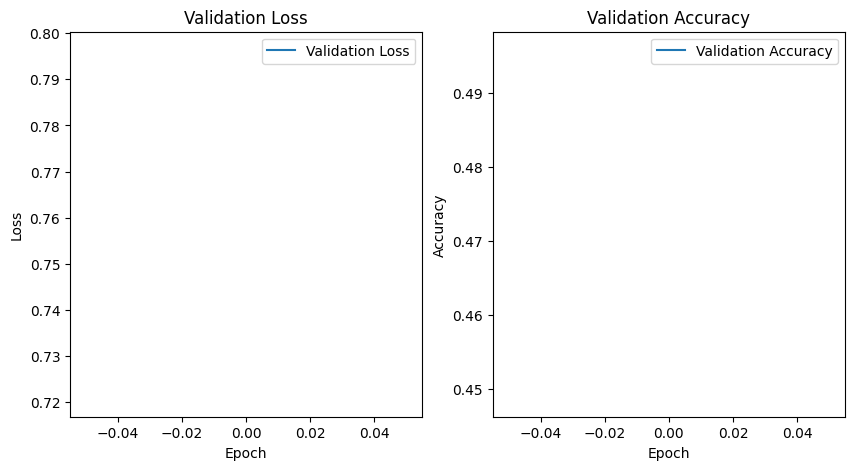

In [80]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, transforms
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
import numpy as np

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Load a pretrained ResNet model and modify the final layer
model = models.resnet18(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 2)  # 2 classes: real and fake
model = model.to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Data transformation
transform = transforms.Compose([transforms.Resize((224, 224)), transforms.ToTensor()])

# Define custom dataset class (as previously done)
class CustomImageDataset(Dataset):
    def __init__(self, image_dir, label, transform=None):
        self.image_dir = image_dir
        self.label = label
        self.transform = transform
        self.image_paths = [os.path.join(image_dir, img) for img in os.listdir(image_dir) if os.path.isfile(os.path.join(image_dir, img))]

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image, self.label

# Load the 'real' and 'fake' validation data
val_real_path = 'C:/Users/benab/Downloads/DEEP_FAKE_PROJET_IA/kaggle/input/dataset/val/real'
val_fake_path = 'C:/Users/benab/Downloads/DEEP_FAKE_PROJET_IA/kaggle/input/dataset/val/fake'
val_real_dataset = CustomImageDataset(image_dir=val_real_path, label=0, transform=transform)  # Label 0 for real
val_fake_dataset = CustomImageDataset(image_dir=val_fake_path, label=1, transform=transform)  # Label 1 for fake

# Combine the datasets
val_dataset = ConcatDataset([val_real_dataset, val_fake_dataset])

# Create a combined data loader
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=True)

# Training function
def evaluate_model(model, val_loader, criterion):
    model.eval()
    val_loss = 0.0
    all_labels = []
    all_preds = []

    with torch.no_grad():
        for images, labels in val_loader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * images.size(0)

            _, preds = torch.max(outputs, 1)
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())

    val_loss /= len(val_loader.dataset)
    val_accuracy = accuracy_score(all_labels, all_preds)
    return val_loss, val_accuracy

# Evaluate the model
val_loss, val_accuracy = evaluate_model(model, val_loader, criterion)
print(f'Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}')

# Plot the results
plt.figure(figsize=(10, 5))

# Plot loss
plt.subplot(1, 2, 1)
plt.plot(val_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Validation Loss')
plt.legend()

# Plot accuracy
plt.subplot(1, 2, 2)
plt.plot(val_accuracy, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Validation Accuracy')
plt.legend()

plt.show()
